In [1]:
from darts.datasets import *
from darts.models.forecasting.pl_forecasting_module import (
    PLPastCovariatesModule,
    io_processor,)


from darts.models.forecasting.torch_forecasting_model import PastCovariatesTorchModel
import torch
import torch.nn as nn

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
series = ElectricityConsumptionZurichDataset().load()

In [57]:
series.components

Index(['Value_NE5', 'Value_NE7', 'Hr [%Hr]', 'RainDur [min]', 'StrGlo [W/m2]',
       'T [°C]', 'WD [°]', 'WVs [m/s]', 'WVv [m/s]', 'p [hPa]'],
      dtype='object', name='component')

In [3]:
start_date = pd.Timestamp('2022-01-12')
end_date = pd.Timestamp('2022-01-15')

<Axes: xlabel='Timestamp'>

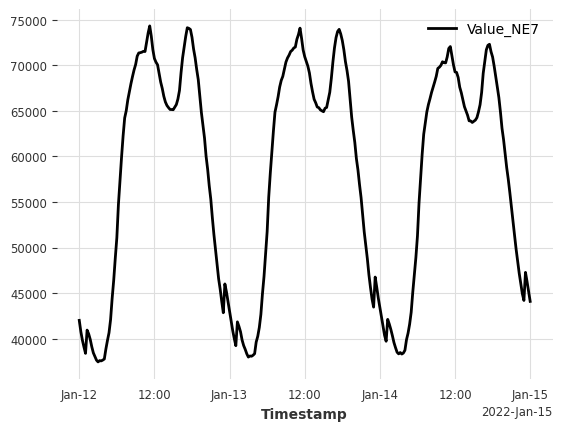

In [58]:
series['Value_NE7'].slice(start_ts=start_date, end_ts=end_date).plot()

In [17]:
class _BaseModule(PLPastCovariatesModule):
    def __init__(self, input_size, hidden_size, output_size, nr_params :int,  **kwargs):
        super().__init__(**kwargs)
        self.hidden = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)
        self.input_size = input_size
        self.target_size = output_size
        self.nr_params = nr_params
        self.target_length = self.output_chunk_length
    @io_processor
    def forward(self, x_in : tuple):
        data, _  = x_in
        print("shape 1 : ", data.shape)
        data = data.permute(1, 0, 2)
        data = self.hidden(data)
        data = self.activation(data)
        out = self.output(data)
        print("shape 2 : ", out.shape)
        predictions = out
        predictions = predictions.view(
            -1, self.target_length, self.target_size, self.nr_params
        )
        print("shape 3 : ", predictions.shape)
        return predictions

In [18]:
class BaseModel(PastCovariatesTorchModel):
    def __init__(
        self,
        input_chunk_length: int,
        output_chunk_length: int,
        hidden_size : int = 12024, 
        output_chunk_shift: int = 0,
        **kwargs):

        super().__init__(**self._extract_torch_model_params(**self.model_params))

        # extract pytorch lightning module kwargs
        self.pl_module_params = self._extract_pl_module_params(**self.model_params)
        self.hidden_size = hidden_size
    @property
    def supports_multivariate(self) -> bool:
        return True
    def _create_model(self, train_sample: tuple[torch.Tensor]) -> torch.nn.Module:
        # samples are made of (past_target, past_covariates, future_target)
        input_dim = train_sample[0].shape[1] + (
            train_sample[1].shape[1] if train_sample[1] is not None else 0
        )
        output_dim = train_sample[-1].shape[1]
        nr_params = 1 if self.likelihood is None else self.likelihood.num_parameters

        return _BaseModule(
            input_size=input_dim,
            output_size=output_dim,
            hidden_size=self.hidden_size,
            nr_params=nr_params,
            **self.pl_module_params,
        )


In [64]:
target = series['Value_NE5'][:1000]

In [19]:
model = BaseModel(input_chunk_length=4*24, output_chunk_length=4*24, hidden_size=2048, n_epochs = 10)

In [20]:
model.fit(target)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_criterion | MSELoss          | 0     
2 | val_criterion   | MSELoss          | 0     
3 | train_metrics   | MetricCollection | 0     
4 | val_metrics     | MetricCollection | 0     
5 | hidden          | Linear           | 4.1 K 
6 | activation      | ReLU             | 0     
7 | output          | Linear           | 2.0 K 
-----------------------------------------------------
6.1 K     Trainable params
0         Non-trainable params
6.1 K     Total params
0.025     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 9

`Trainer.fit` stopped: `max_epochs=10` reached.


shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 9

BaseModel(hidden_size=2048, output_chunk_shift=0, input_chunk_length=96, output_chunk_length=96, n_epochs=10)

In [21]:
pred = model.predict(24*6)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

shape 1 :  torch.Size([1, 96, 1])
shape 2 :  torch.Size([96, 1, 1])
shape 3 :  torch.Size([1, 96, 1, 1])
shape 1 :  torch.Size([1, 96, 1])
shape 2 :  torch.Size([96, 1, 1])
shape 3 :  torch.Size([1, 96, 1, 1])


<Axes: xlabel='Timestamp'>

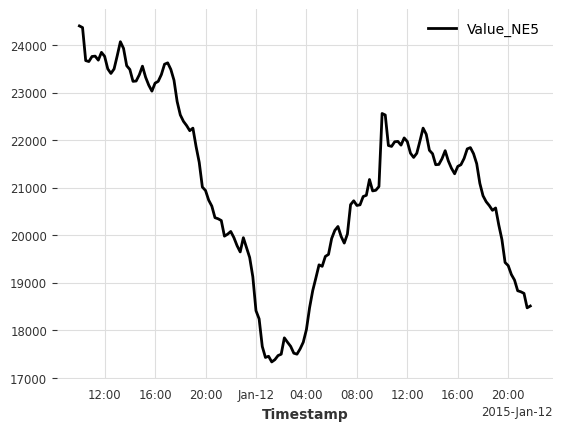

In [11]:
pred.plot()

In [155]:
__all__ = ['PatchTST']

# Cell
from typing import Callable, Optional
import torch
from torch import nn
from torch import Tensor
import torch.nn.functional as F
import numpy as np

from layers.PatchTST_backbone import PatchTST_backbone
from layers.PatchTST_layers import series_decomp
from darts.models.forecasting.pl_forecasting_module import (
    PLPastCovariatesModule,
    io_processor,)


class Model(PLPastCovariatesModule):
    def __init__(self, configs, input_size : int , output_size : int,  max_seq_len: Optional[int] = 1024, d_k: Optional[int] = None, d_v: Optional[int] = None, norm: str = 'BatchNorm', attn_dropout: float = 0.,
                 act: str = "gelu", key_padding_mask: bool = 'auto', padding_var: Optional[int] = None, attn_mask: Optional[Tensor] = None, res_attention: bool = True,
                 pre_norm: bool = False, store_attn: bool = False, pe: str = 'zeros', learn_pe: bool = True, pretrain_head: bool = False, head_type='flatten', verbose: bool = False, nr_params : int = 1, **kwargs):

        super().__init__(**kwargs)

        # load parameters
        c_in = configs.enc_in
        context_window = configs.seq_len
        target_window = configs.pred_len

        n_layers = configs.e_layers
        n_heads = configs.n_heads
        d_model = configs.d_model
        d_ff = configs.d_ff
        dropout = configs.dropout
        fc_dropout = configs.fc_dropout
        head_dropout = configs.head_dropout

        individual = configs.individual

        patch_len = configs.patch_len
        stride = configs.stride
        padding_patch = configs.padding_patch

        revin = configs.revin
        affine = configs.affine
        subtract_last = configs.subtract_last

        decomposition = configs.decomposition
        kernel_size = configs.kernel_size
        self.input_size = input_size
        self.target_size = output_size
        self.nr_params = nr_params
        self.target_length = self.output_chunk_length
        # model
        self.decomposition = decomposition
        if self.decomposition:
            self.decomp_module = series_decomp(kernel_size)
            self.model_trend = PatchTST_backbone(c_in=c_in, context_window=context_window, target_window=target_window, patch_len=patch_len, stride=stride,
                                                 max_seq_len=max_seq_len, n_layers=n_layers, d_model=d_model,
                                                 n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm, attn_dropout=attn_dropout,
                                                 dropout=dropout, act=act, key_padding_mask=key_padding_mask, padding_var=padding_var,
                                                 attn_mask=attn_mask, res_attention=res_attention, pre_norm=pre_norm, store_attn=store_attn,
                                                 pe=pe, learn_pe=learn_pe, fc_dropout=fc_dropout, head_dropout=head_dropout, padding_patch=padding_patch,
                                                 pretrain_head=pretrain_head, head_type=head_type, individual=individual, revin=revin, affine=affine,
                                                 subtract_last=subtract_last, verbose=verbose, **kwargs)
            self.model_res = PatchTST_backbone(c_in=c_in, context_window=context_window, target_window=target_window, patch_len=patch_len, stride=stride,
                                               max_seq_len=max_seq_len, n_layers=n_layers, d_model=d_model,
                                               n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm, attn_dropout=attn_dropout,
                                               dropout=dropout, act=act, key_padding_mask=key_padding_mask, padding_var=padding_var,
                                               attn_mask=attn_mask, res_attention=res_attention, pre_norm=pre_norm, store_attn=store_attn,
                                               pe=pe, learn_pe=learn_pe, fc_dropout=fc_dropout, head_dropout=head_dropout, padding_patch=padding_patch,
                                               pretrain_head=pretrain_head, head_type=head_type, individual=individual, revin=revin, affine=affine,
                                               subtract_last=subtract_last, verbose=verbose, **kwargs)
        else:
            self.model = PatchTST_backbone(c_in=c_in, context_window=context_window, target_window=target_window, patch_len=patch_len, stride=stride,
                                           max_seq_len=max_seq_len, n_layers=n_layers, d_model=d_model,
                                           n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm, attn_dropout=attn_dropout,
                                           dropout=dropout, act=act, key_padding_mask=key_padding_mask, padding_var=padding_var,
                                           attn_mask=attn_mask, res_attention=res_attention, pre_norm=pre_norm, store_attn=store_attn,
                                           pe=pe, learn_pe=learn_pe, fc_dropout=fc_dropout, head_dropout=head_dropout, padding_patch=padding_patch,
                                           pretrain_head=pretrain_head, head_type=head_type, individual=individual, revin=revin, affine=affine,
                                           subtract_last=subtract_last, verbose=verbose, **kwargs)

    def forward(self, x_in):
        x, _ = x_in          # x: [Batch, Input length, Channel]
        print("size", x.size())
        if self.decomposition:
            res_init, trend_init = self.decomp_module(x)
            print("res_init : ", res_init.shape)
            print("trend_init :", trend_init.shape)
            res_init, trend_init = res_init.permute(0, 2, 1), trend_init.permute(
                0, 2, 1)  # x: [Batch, Channel, Input length]
            res = self.model_res(res_init)
            trend = self.model_trend(trend_init)
            x = res + trend
            print(x)
            x = x.permute(0, 2, 1)
            predictions = x
            print("shape 4 :", predictions.shape)
            predictions = predictions.view(
            -1, self.target_length, self.target_size, self.nr_params
        )
            print("shape 5 :", predictions.shape)    # x: [Batch, Input length, Channel]
        else:
            x = x.permute(0, 2, 1)    # x: [Batch, Channel, Input length]
            x = self.model(x)
            x = x.permute(0, 2, 1)
            predictions = x
            predictions = predictions.view(
            -1, self.target_length, self.target_size, self.nr_params
        )




        return predictions  
            



In [156]:
from darts.models.forecasting.torch_forecasting_model import PastCovariatesTorchModel
# Adjust this import based on your environment
import torch

from dataclasses import dataclass
from darts.models.forecasting.pl_forecasting_module import PLForecastingModule
import inspect


@dataclass
class Config:
    enc_in: int
    seq_len: int
    pred_len: int
    e_layers: int
    n_heads: int
    d_model: int
    d_ff: int
    fc_dropout: float
    dropout: float
    head_dropout: float
    individual: int
    patch_len: int
    stride: int
    padding_patch: str
    revin: int
    affine: int
    subtract_last: int
    decomposition: int
    kernel_size: int


class PatchTSTModel(PastCovariatesTorchModel):
    def __init__(self,
                 input_chunk_length: int,
                 output_chunk_length: int,
                 output_chunk_shift: int = 0,
                 enc_in: int = 7,
                 n_layers: int = 8,
                 n_heads: int = 8,
                 d_model: int = 512,
                 d_ff: int = 2048,
                 fc_dropout: float = 0.05,
                 dropout: float = 0.05,
                 head_dropout: float = 0,
                 individual: int = 0,
                 patch_len: int = 16,
                 stride: int = 8,
                 padding_patch='end',
                 revin: int = 0,
                 affine: int = 0,
                 subtract_last: int = 0,
                 decomposition: int = 0,
                 kernel_size: int = 25,

                 **kwargs):
        """
        PatchTST implementation with PastCovariatesTorchModel integration.

        Parameters:
        - input_size: Length of the input window (look-back period).
        - patch_len: Length of each patch (default: 16).
        - stride: Stride between patches (default: 8).
shape 1 :  torch.Size([32, 96, 1])
shape 2 :  torch.Size([96, 32, 1])
shape 3 :  torch.Size([32, 96, 1, 1])
shape 1 :  torch.Size([32, 96, 1])
        - num_layers: Number of Transformer layers (default: 2).
        - dropout: Dropout probability (default: 0.1).
        - output_chunk_length: Number of time steps to predict.
        - lr: Learning rate.
        - batch_size: Batch size during training.
        - kwargs: Additional arguments for the PastCovariatesTorchModel.
        """
        self._configs = Config(enc_in=enc_in, seq_len=input_chunk_length, pred_len=output_chunk_length, e_layers=n_layers, n_heads=n_heads, d_model=d_model, d_ff=d_ff, fc_dropout=fc_dropout, dropout=dropout, head_dropout=head_dropout,
                               individual=individual, patch_len=patch_len, stride=stride, padding_patch=padding_patch, revin=revin, affine=affine, subtract_last=subtract_last, decomposition=decomposition, kernel_size=kernel_size)

        # Initialize the base class
        super().__init__(**self._extract_torch_model_params(**self.model_params))
        self.pl_module_params = self._extract_pl_module_params(**self.model_params)


    @property
    def supports_multivariate(self) -> bool:
        return True

    def _create_model(self, train_sample: tuple[torch.Tensor]) -> torch.nn.Module:
        """
        Creates and returns the PatchTST model.

        Parameters:
        - input_dim: The number of input features (dimensions of the input time series).
        - output_dim: The number of output features (dimensions of the output time series).
        """
        input_dim = train_sample[0].shape[1] + (
            train_sample[1].shape[1] if train_sample[1] is not None else 0
        )
        output_dim = train_sample[-1].shape[1]
        nr_params = 1 if self.likelihood is None else self.likelihood.num_parameters
        return Model(
            configs=self._configs, input_size = input_dim,   output_size = output_dim, nr_params=nr_params, **self.pl_module_params
        )

In [167]:
model = PatchTSTModel(output_chunk_length =  4*24, input_chunk_length = 4*24, n_epochs=5, decomposition= 1 ,d_model = 256,
                 d_ff = 1024)

In [128]:
target = series['Value_NE5'][:10000]

In [137]:
target_long = series['Value_NE5'][:20000]

<Axes: xlabel='Timestamp'>

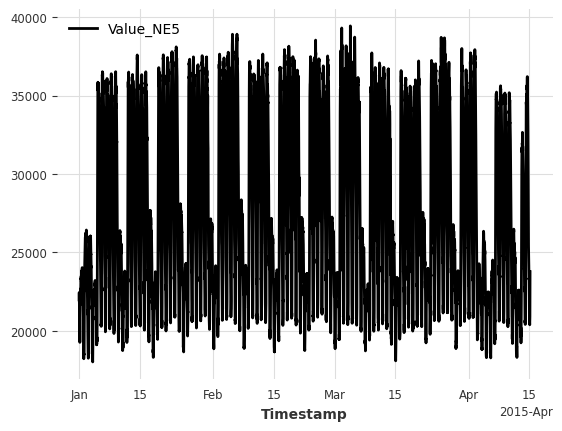

In [129]:
target.plot()

In [109]:
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from darts.dataprocessing.transformers import BoxCox, Scaler

In [130]:
scaler_type = StandardScaler()
scaler = Scaler(scaler=scaler_type, global_fit=True)

In [131]:
target_scaled = scaler.fit_transform(target)

In [138]:
target_long_scaled = scaler.transform(target_long)

<Axes: xlabel='Timestamp'>

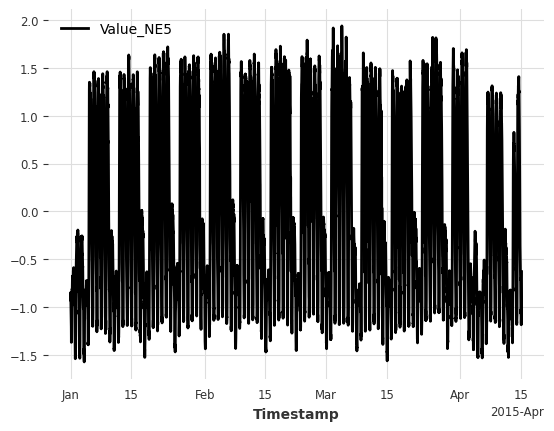

In [132]:
target_scaled.plot()

<Axes: xlabel='Timestamp'>

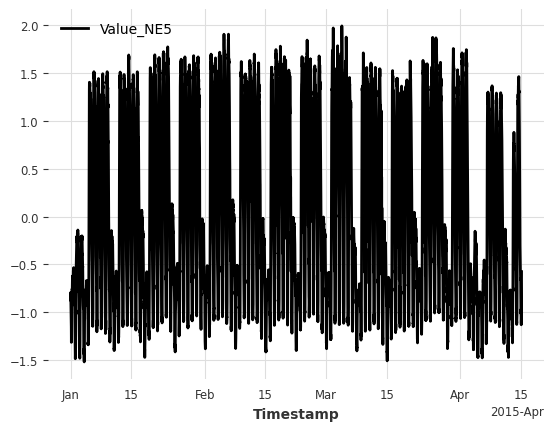

In [121]:
target_scaled[:10000].plot()

In [168]:
model.fit(target_scaled)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 3.81 GiB of which 10.56 MiB is free. Including non-PyTorch memory, this process has 3.79 GiB memory in use. Of the allocated memory 3.62 GiB is allocated by PyTorch, and 78.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [134]:
pred = model.predict(24*4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

size torch.Size([1, 96, 1])
shape 1  torch.Size([1, 96, 1])
shape 2 : torch.Size([1, 1, 480])
shape 3 : torch.Size([1, 480, 1])
shape 4 : torch.Size([1, 480, 1])
shape 5 : torch.Size([1, 480, 1, 1])


<Axes: xlabel='Timestamp'>

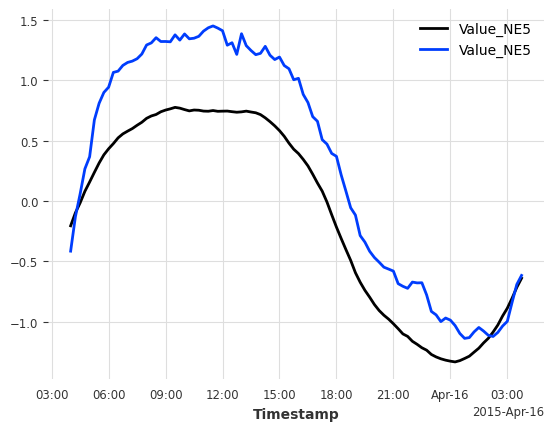

In [140]:
pred.plot()
target_long_scaled[10000 : 10000 + 4*24].plot()

<Axes: xlabel='Timestamp'>

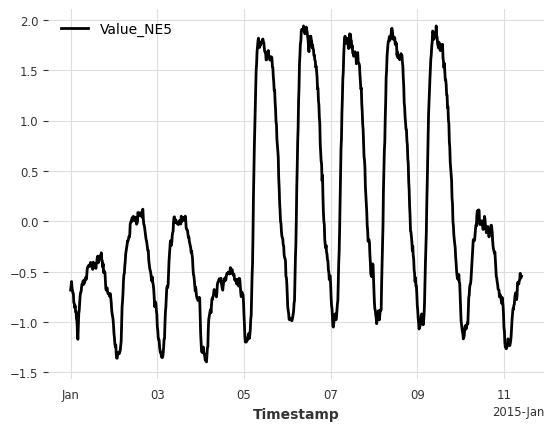

In [82]:
target_scaled.plot()

In [85]:
target_scaled.freq

<15 * Minutes>